In [42]:
import os
import sys
import glob
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import unicodedata
import string
import copy

In [43]:
#writer = SummaryWriter("runs/word-classification")

## 1. Load data

Download and extract the data zip file from [this link](https://download.pytorch.org/tutorial/data.zip). All the .txt files in the names folder can be used to train this word classification model. I have placed those text files in `data/language-words` directory.

In [44]:
data_folder = os.path.join("storage", "data", "language-words")
file_paths = glob.glob(os.path.join(data_folder, "*.txt"))
print(file_paths)

['storage/data/language-words/French.txt', 'storage/data/language-words/Portuguese.txt', 'storage/data/language-words/Chinese.txt', 'storage/data/language-words/Scottish.txt', 'storage/data/language-words/Korean.txt', 'storage/data/language-words/Japanese.txt', 'storage/data/language-words/Dutch.txt', 'storage/data/language-words/Arabic.txt', 'storage/data/language-words/Irish.txt', 'storage/data/language-words/Czech.txt', 'storage/data/language-words/Spanish.txt', 'storage/data/language-words/Vietnamese.txt', 'storage/data/language-words/Russian.txt', 'storage/data/language-words/Greek.txt', 'storage/data/language-words/German.txt', 'storage/data/language-words/English.txt', 'storage/data/language-words/Polish.txt', 'storage/data/language-words/Italian.txt']


In [45]:
words_dict = {}
for file_path in file_paths:
    language = file_path.split("/")[3][:-4]
    with open(file_path, "r") as file:
        words = file.readlines()
        words = [word.strip().lower() for word in words]
        words_dict[language] = words
print(words_dict['German'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']


In [46]:
for language, words in words_dict.items():
    print(language, len(words))

French 277
Portuguese 74
Chinese 268
Scottish 100
Korean 94
Japanese 991
Dutch 297
Arabic 2000
Irish 232
Czech 519
Spanish 298
Vietnamese 73
Russian 9408
Greek 203
German 724
English 3668
Polish 139
Italian 709


## 2. Clean text

In [47]:
characters = set()
for language, words in words_dict.items():
    for word in words:
        characters.update(list(word))
characters = sorted(list(characters))
print(characters)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'õ', 'ö', 'ù', 'ú', 'ü', 'ą', 'ł', 'ń', 'ś', 'ż']


There are many accented characers in the dataset which have to transformed into the raw format.

In [48]:
c = list('ñ')
c_normalised = list(unicodedata.normalize("NFD", 'ñ'))
print(c, c_normalised)

['ñ'] ['n', '̃']


In [49]:
characters_normalised = []
for character in characters:
    character_normalised = unicodedata.normalize("NFD", character)[0]
    characters_normalised.append(character_normalised)
print(characters_normalised)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'a', 'a', 'a', 'a', 'c', 'e', 'e', 'e', 'i', 'i', 'n', 'o', 'o', 'o', 'o', 'u', 'u', 'u', 'a', 'ł', 'n', 's', 'z']


In [50]:
characters_all = list(string.ascii_lowercase + " -',:;")
print(len(characters_all), characters_all)

32 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '-', "'", ',', ':', ';']


In [51]:
def clean_word(word):
    cleaned_word = ""
    for character in word:
        for character_raw in unicodedata.normalize('NFD', character):
            if character_raw in characters_all:
                cleaned_word += character_raw
    return cleaned_word

In [52]:
words_dict_cleaned = {}
for language, words in words_dict.items():
    cleaned_words = []
    for word in words:
        cleaned_word = clean_word(word)
        cleaned_words.append(cleaned_word)
    words_dict_cleaned[language] = cleaned_words

In [53]:
print(words_dict['German'][-10:])
print(words_dict_cleaned['German'][-10:])
print(words_dict['Portuguese'][-10:])
print(words_dict_cleaned['Portuguese'][-10:])
print(words_dict['Polish'][-10:])
print(words_dict_cleaned['Polish'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['wolter', 'worner', 'wornhor', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['santos', 'serafim', 'silva', 'silveira', 'simões', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['santos', 'serafim', 'silva', 'silveira', 'simoes', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'żuraw']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'zuraw']


In [54]:
words_dict = copy.deepcopy(words_dict_cleaned)
del words_dict_cleaned

## 3. Define utilities

In [55]:
num_langs = len(words_dict.keys())
num_chars = len(characters_all)
print(num_langs, num_chars)

18 32


In [56]:
max_timesteps = 0
for language, words in words_dict.items():
    for word in words:
        if len(word) > max_timesteps:
            max_timesteps = len(word)
print(max_timesteps)

20


In [57]:
lang_to_id = {k:v for k, v in zip(sorted(list(words_dict.keys())), range(len(words_dict.keys())))}
print(lang_to_id)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}


In [58]:
id_to_lang = {v:k for k, v in lang_to_id.items()}
print(id_to_lang)

{0: 'Arabic', 1: 'Chinese', 2: 'Czech', 3: 'Dutch', 4: 'English', 5: 'French', 6: 'German', 7: 'Greek', 8: 'Irish', 9: 'Italian', 10: 'Japanese', 11: 'Korean', 12: 'Polish', 13: 'Portuguese', 14: 'Russian', 15: 'Scottish', 16: 'Spanish', 17: 'Vietnamese'}


In [59]:
char_to_id = {k:v for k, v in zip(characters_all, range(len(characters_all)))}
print(char_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '-': 27, "'": 28, ',': 29, ':': 30, ';': 31}


In [60]:
id_to_char = {v:k for k, v in char_to_id.items()}
print(id_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '-', 28: "'", 29: ',', 30: ':', 31: ';'}


## 4. Split data

In [62]:
words_df = []
for language, words in tqdm(words_dict.items()):
    for word in words:
        words_df.append({"word":word, "language":language})
words_df = pd.DataFrame(words_df)
print(words_df.shape)
words_df.head()


(20074, 2)


,word,language
0,abel,French
1,abraham,French
2,adam,French
3,albert,French
4,allard,French


In [63]:
words_df_train, words_df_test = train_test_split(words_df, train_size=0.8, stratify=words_df["language"], random_state=0)
words_df_train = words_df_train.reset_index(drop=True)
words_df_test = words_df_test.reset_index(drop=True)
print(words_df_train.shape)
print(words_df_test.shape)

(16059, 2)
(4015, 2)


In [64]:
train_count = words_df_train["language"].value_counts().rename("Train")
test_count = words_df_test["language"].value_counts().rename("Test")
count = pd.concat([train_count, test_count], axis=1, sort=True).T
count.loc["Total", :] = count.sum(axis=0) # add row
count.loc[:, "Total"] = count.sum(axis=1) # add col
count = count.astype("int")
count

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese,Total
Train,1600,214,415,238,2934,222,579,163,186,567,793,75,111,59,7526,80,238,59,16059
Test,400,54,104,59,734,55,145,40,46,142,198,19,28,15,1882,20,60,14,4015
Total,2000,268,519,297,3668,277,724,203,232,709,991,94,139,74,9408,100,298,73,20074


## 5. Define dataset

Our PyTorch RNN based model will take input of `Size([mini_batch_size, timesteps, input_size])` and produce output of `Size([mini_batch_size, output_size])`. In order to make uniform timesteps across different words, let us pad with space.

In [65]:
class WordDataset(Dataset):
    
    def __init__(self, words_df):
        self.words_df = words_df
    
    def __len__(self):
        self.len = len(self.words_df)
        return self.len
    
    def __getitem__(self, idx):
        row = self.words_df.iloc[idx, :]
        
        word = row['word'].ljust(max_timesteps)
        x = torch.zeros((max_timesteps, num_chars)) # [timesteps, input_size]
        for i, char in enumerate(word):
            x[i, char_to_id[char]] = 1
        
        # y = np.zeros(num_langs) # [output_size]
        # y[lang_to_id[row['language']]] = 1
        y = lang_to_id[row['language']]
        
        return x, y  

In [66]:
train_set = WordDataset(words_df_train)
test_set = WordDataset(words_df_test)

## 6. Define dataloader

In [161]:
train_batch_size = 128
test_batch_size = 4

In [162]:
num_cpus = os.cpu_count()
print(num_cpus)

8


In [163]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=num_cpus)

In [164]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
print(X.size(), Y.size())

torch.Size([128, 20, 32]) torch.Size([128])


In [173]:
len_train_loader = len(train_loader)
print(len_train_loader)

126


## 7. Define model

In [222]:
hidden_size = 24
num_layers = 2

In [223]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [224]:
class Model(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        out, ht = self.lstm1(X, (h0, c0)) # out -> [batch_size, time_steps, input_size]
        outn = out[:,-1,:]
        outn = outn.contiguous().view(batch_size, self.hidden_size)
        outn = self.fc2(outn)
        return outn

In [225]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (lstm1): LSTM(32, 24, num_layers=2, batch_first=True)
    (fc2): Linear(in_features=24, out_features=18, bias=True)
  )
)


In [226]:
#list(model.parameters())
for p in model.parameters():
    print(p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [227]:
#summary(model, input_size=(max_timesteps, num_chars))

In [228]:
#writer.add_graph(model, X)
#writer.close()

## 8. Set optimizer

In [230]:
lr = 0.01
step_size = len_train_loader * 4
gamma = 0.95
print(step_size)

504


In [232]:
alpha = 0.6
weights = len(words_df_train) / (words_df_train['language'].value_counts() ** alpha)
weights = weights / weights.sum()
weights = weights.sort_index()
print(weights)

Arabic        0.016187
Chinese       0.054123
Czech         0.036375
Dutch         0.050779
English       0.011250
French        0.052944
German        0.029787
Greek         0.063726
Irish         0.058874
Italian       0.030163
Japanese      0.024664
Korean        0.101530
Polish        0.080249
Portuguese    0.117252
Russian       0.006393
Scottish      0.097673
Spanish       0.050779
Vietnamese    0.117252
Name: language, dtype: float64


In [233]:
weights = torch.Tensor(weights).to(device)
print(weights)

tensor([0.0162, 0.0541, 0.0364, 0.0508, 0.0113, 0.0529, 0.0298, 0.0637, 0.0589,
        0.0302, 0.0247, 0.1015, 0.0802, 0.1173, 0.0064, 0.0977, 0.0508, 0.1173],
       device='cuda:0')


In [234]:
criterion = nn.CrossEntropyLoss(weight=weights, reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

## 9. Train model

In [235]:
epochs = 100
print_every_n_epochs = 1

In [ ]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0
    
    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)

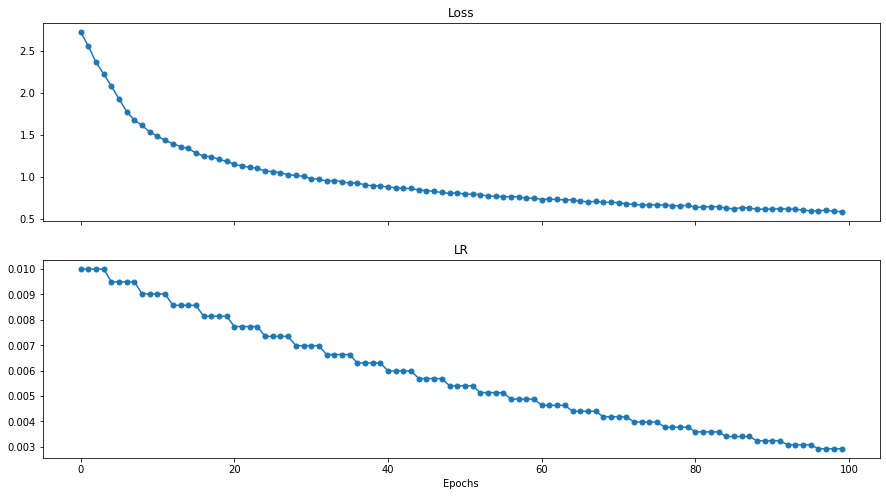

In [237]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

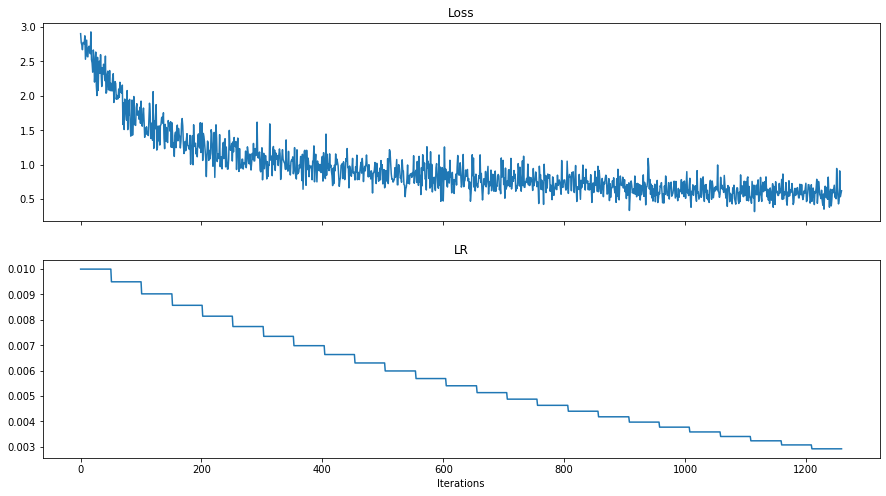

In [238]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::10])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::10])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

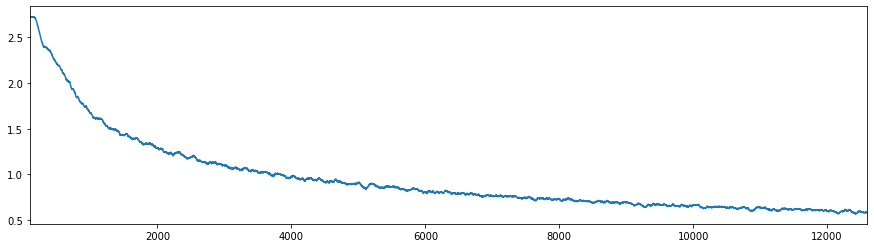

In [239]:
window = 100
plt.figure(figsize=(15, 4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [240]:
path = os.path.join("storage", "models", "language-words", "classifier.pth")
torch.save(model.state_dict(), path)

## 10. Test Model

In [241]:
path = os.path.join("storage", "models", "language-words", "classifier.pth")
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))
#model = model.to("cpu")

<All keys matched successfully>

In [242]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

In [243]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

In [244]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.8238993710691824
Test Accuracy: 0.7364881693648817


In [245]:
mat = np.array([1, 2, 3])
print(mat.shape)
print(mat[:, np.newaxis].shape)

(3,)
(3, 1)


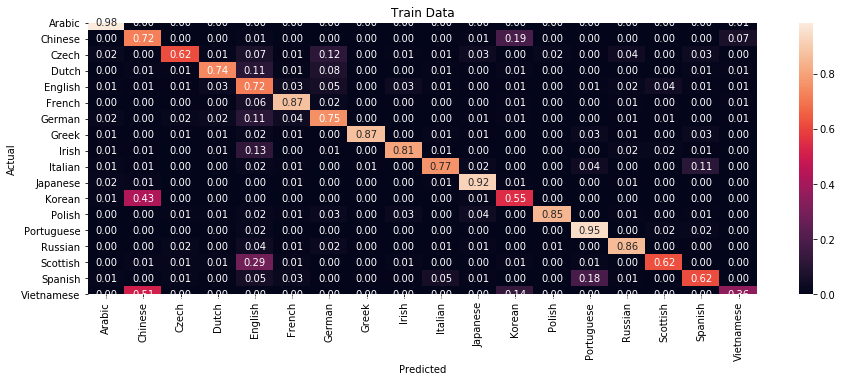

In [246]:
labels = sorted(list(lang_to_id.keys()))
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_train = c_mat_train / c_mat_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,5))
sns.heatmap(c_mat_train, annot=True, fmt="0.2f", xticklabels=labels, yticklabels=labels)
plt.title('Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

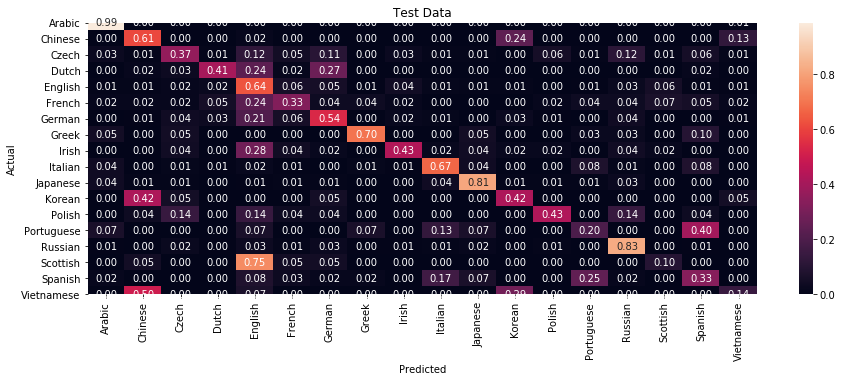

In [247]:
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
c_mat_test = c_mat_test / c_mat_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 5))
sns.heatmap(c_mat_test, annot=True, fmt='0.2f', xticklabels=labels, yticklabels=labels)
plt.title('Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [248]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies

In [249]:
compute_accuracies(c_mat_train)

{'Arabic': 0.9850000000000001,
 'Chinese': 0.7196261682242991,
 'Czech': 0.6192771084337351,
 'Dutch': 0.7394957983193279,
 'English': 0.7191547375596455,
 'French': 0.8738738738738739,
 'German': 0.7547495682210709,
 'Greek': 0.8711656441717791,
 'Irish': 0.8064516129032259,
 'Italian': 0.7671957671957672,
 'Japanese': 0.9205548549810845,
 'Korean': 0.5466666666666666,
 'Polish': 0.8468468468468469,
 'Portuguese': 0.9491525423728815,
 'Russian': 0.8584905660377359,
 'Scottish': 0.625,
 'Spanish': 0.6176470588235294,
 'Vietnamese': 0.3559322033898305}

In [250]:
compute_accuracies(c_mat_test)

{'Arabic': 0.9875000000000002,
 'Chinese': 0.6111111111111112,
 'Czech': 0.36538461538461536,
 'Dutch': 0.4067796610169492,
 'English': 0.6362397820163488,
 'French': 0.32727272727272727,
 'German': 0.5379310344827586,
 'Greek': 0.7,
 'Irish': 0.43478260869565216,
 'Italian': 0.6690140845070423,
 'Japanese': 0.8131313131313131,
 'Korean': 0.42105263157894746,
 'Polish': 0.4285714285714286,
 'Portuguese': 0.2,
 'Russian': 0.8251859723698194,
 'Scottish': 0.1,
 'Spanish': 0.3333333333333333,
 'Vietnamese': 0.14285714285714285}